In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/Computer_Vision/Files/'

Mounted at /content/drive
CameraCalibration1.jpg	ComputerVision1.pdf   Image.jpg  img4.png
CameraCalibration2.jpg	ComputerVision2.pdf   img1.jpg	 StereoVision.png
CameraCalibration3.jpg	EpipolarGeometry.png  img2.jpg
CameraCalibration4.jpg	Frame.png	      img3.png


# <i><b><font color='blue'> I - AlexNet Model </font></b></i>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import Tensor
from torch import nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
class pAlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, (11, 11), (4, 4), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(64, 192, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),

            nn.Conv2d(192, 384, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(384, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
            nn.ReLU(True),
            nn.MaxPool2d((3, 3), (2, 2)),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out



class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x


In [ ]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AlexNet( 10 )
model.to( device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.99)

In [7]:
data, target = next(iter(train_loader))
data = Variable(data)

print( data.shape)

torch.Size([50, 1, 28, 28])


tensor(0.)


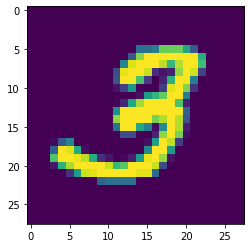

In [12]:
from random import randint

n = randint( 0, int( data.shape[0]-1))

print( torch.min( data[n][0]) )
plt.imshow( data[n,0] )

In [ ]:
model.train()
train_loss = []

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    outputs = model( data )
    loss = criterion( outputs, target)
    loss.backward()
    optimizer.step()

    train_loss.append( loss.item() )

    if batch_idx % 20 == 0:
        print('Train Step: {}\tLoss: {:.3f} '.format( batch_idx, loss.item() ))


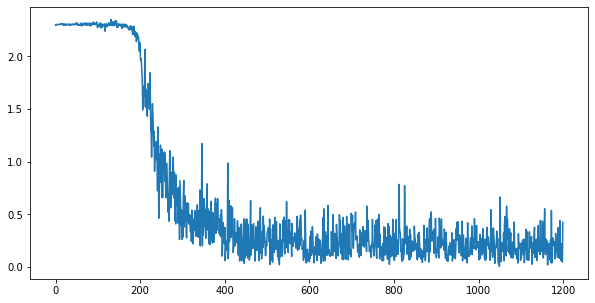

In [ ]:
plt.figure( figsize=(10,5) )
plt.plot(np.arange(len(train_loss)), train_loss)
plt.show()

In [ ]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 97.56%


In [ ]:
example = torch.rand(1, 1, 28, 28 )

tsm = torch.jit.script( model.cpu() , example)
tsm.save( "/content/drive/MyDrive/Computer_Vision/traced_resnet_model.pt" )

print( "done" )

done


/usr/local/lib/python3.7/dist-packages/torch/jit/_script.py:1244: UserWarning: `optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead
  "`optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead"
